In [1]:
from keras.applications.vgg16 import VGG16
from keras.layers import merge, Input
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import csv
import cv2
import sklearn
import keras
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/carnd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/carnd/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
image_input = Input(shape=(224, 224, 3))
model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
 model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [5]:
print(model.layers[-1].trainable)
num_classes = 39

True


In [6]:

# last_layer = model.get_layer('fc2').output
# # x = Dense(1000, activation='relu')(last_layer)
# # out = Dense(38, activation='softmax', name='output')(x)
# out = Dense(num_classes, activation='softmax', name='output')(last_layer)
# custom_vgg_model = Model(image_input, out)
# custom_vgg_model.summary()

In [7]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dense(500, activation='relu', name='fc2')(x)
out = Dense(39, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
data = []
with open('./new_lables.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append([row[0],int(row[-1])])
print(data[1])

['Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG', 1]


In [9]:
train_samples, validation_samples = train_test_split(data, test_size=0.2)

In [10]:
print(len(data))
dict = {1:"Apple_scab",2:"Black_rot",3:"Cedar_apple_rust",4:"healthy",5:"Powdery_mildew",6:"Cercospora_leaf_spot Gray_leaf_spot",7:"Common_rust_",8:"Northern_Leaf_Blight",9:"Esca_Black_Measles",10:"Leaf_blight_Isariopsis_Leaf_Spot",11:"Haunglongbing_Citrus_greening",12:"Bacterial_spot",13:"Early_blight",14:"Late_blight",15:"Leaf_scorch",16:"Leaf_Mold",17:"Septoria_leaf_spot",18:"Spider_mites Two-spotted_spider_mite",19:"Target_Spot",20:"Tomato_mosaic_virus",21:"Tomato_Yellow_Leaf_Curl_Virus",22:"Apple_Frogeye_Spot"}

51830


In [11]:
def preprocess(image_list):
    not_match = []
    images=[]
    labels=[]
    for image_lable in image_list:                  
        image = mpimg.imread("./PlantVillage-Dataset/raw/color/"+image_lable[0])
        image = cv2.resize(image, (224, 224))
        images.append(image)
        labels.append(image_lable[1])
    
    return images,labels

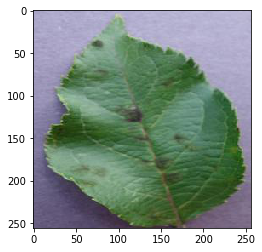

In [12]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_images,batch_lables= preprocess(samples[offset:offset+batch_size])
            x_train=np.asfarray(batch_images)
            #x_train=keras.utils.to_categorical(x_train, num_classes=32)
            y_train=np.asfarray(batch_lables)
            y_train=keras.utils.to_categorical(y_train, num_classes=39)
            #print(x_train,y_train)
            yield (x_train, y_train)

plt.imshow(mpimg.imread('./PlantVillage-Dataset/raw/color/'+data[0][0]))

In [13]:
train_generator = generator(train_samples, batch_size=32)

validation_generator = generator(validation_samples, batch_size=32)

In [ ]:
custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
#custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
custom_vgg_model2.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=2)
custom_vgg_model2.save('model.h5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/home/carnd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/carnd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=41464, epochs=2, validation_steps=10366)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/2
   18/41464 [..............................] - ETA: 378526s - loss: 14.4754 - acc: 0.0938

In [ ]:
#print(generator(train_samples, batch_size=32))
for items in (train_generator):
    print(items)


In [ ]:
generator(train_samples, batch_size=32)